In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib as mpl
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx

import warnings

warnings.filterwarnings('ignore')

## Select the reservoir

In [3]:
SAVE = True
RESERVOIR = 1

start_date = pd.to_datetime('2023-07-21')  # clip to data only after science orbit began.

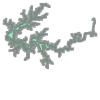

In [4]:
reservoir_boundaries = gpd.read_file(Path('/tiger1/pdas47/resorr-swot/data/cumberland-reservoirs/03-cumberland-reservoirs.geojson'))

selected_reservoirs = reservoir_boundaries['id'].tolist()
res_names = reservoir_boundaries[['id', 'name']].set_index('id').to_dict()['name']

RESERVOIR_NAME = res_names[RESERVOIR]
RESERVOIR_GDF = reservoir_boundaries[reservoir_boundaries['id'] == RESERVOIR]
RESERVOIR_GEOMETRY = RESERVOIR_GDF.geometry.iloc[0]

RESERVOIR_GEOMETRY

In [5]:
BUFFER_M = 800 # m

utm_crs = reservoir_boundaries[reservoir_boundaries['id'] == RESERVOIR].estimate_utm_crs()
print(f"UTM area of use: \n{utm_crs.area_of_use}")

buffered_roi_utm = reservoir_boundaries[reservoir_boundaries['id'] == RESERVOIR].to_crs(utm_crs).buffer(BUFFER_M).to_crs('epsg:4326')
BUFFERED_RESERVOIR_GDF = gpd.GeoDataFrame(buffered_roi_utm).rename({0: 'geometry'}, axis=1) # .hvplot(alpha=0.2, lw=2)
BUFFERED_RESERVOIR_GDF.set_geometry('geometry', inplace=True)
BUFFERED_RESERVOIR_GEOMETRY = BUFFERED_RESERVOIR_GDF.geometry.iloc[0]

UTM area of use: 
- name: Between 90°W and 84°W, northern hemisphere between equator and 84°N, onshore and offshore. Belize. Canada - Manitoba; Nunavut; Ontario. Costa Rica. Cuba. Ecuador - Galapagos. El Salvador. Guatemala. Honduras. Mexico. Nicaragua. United States (USA).
- bounds: (-90.0, 0.0, -84.0, 84.0)


In [6]:
gd_track_fn = Path('/tiger1/pdas47/resorr-swot/data/swot_orbit/swot_orbit.geojson')
gd_track = gpd.read_file(gd_track_fn)
gd_track

,ID_PASS,START_TIME,geometry
0,1,Day 01 00:00:00,"MULTIPOLYGON (((-75.4587 -77.45455, -75.73434 ..."
1,2,Day 01 00:51:30,"MULTIPOLYGON (((84.56768 77.75119, 84.6008 78...."
2,2,Day 01 00:51:30,"MULTIPOLYGON (((-180 -52.37417, -180 -50.92787..."
3,3,Day 01 01:42:50,"MULTIPOLYGON (((-110.19573 -77.57156, -110.161..."
4,4,Day 01 02:34:20,"MULTIPOLYGON (((57.70091 77.75254, 57.69643 78..."
...,...,...,...
845,582,Day 21 18:10:40,"MULTIPOLYGON (((136.37126 77.75111, 136.40526 ..."
846,582,Day 21 18:10:40,"MULTIPOLYGON (((-180 72.80747, -180 73.45033, ..."
847,583,Day 21 19:02:00,"MULTIPOLYGON (((-58.39258 -77.57164, -58.3595 ..."
848,584,Day 21 19:53:30,"MULTIPOLYGON (((109.50449 77.75255, 109.5009 7..."


In [7]:
gd_nadir_fn = Path('/tiger1/pdas47/resorr-swot/data/swot_orbit/nadir/swot_science_orbit_sept2015-v2_nadir.shp')
gd_nadir = gpd.read_file(gd_nadir_fn)
gd_nadir.head()

,ID_PASS,START_TIME,geometry
0,1,Day 01 00:00:00,"LINESTRING (-75.40128 -77.54325, -67.74948 -77..."
1,2,Day 01 00:51:30,"LINESTRING (84.56135 77.66162, 92.5227 77.5155..."
2,2,Day 01 00:51:30,"LINESTRING (-180 -52.65544, -179.4133 -53.7198..."
3,3,Day 01 01:42:50,"LINESTRING (-110.20279 -77.66112, -107.53758 -..."
4,4,Day 01 02:34:20,"LINESTRING (57.70176 77.66297, 60.37721 77.650..."


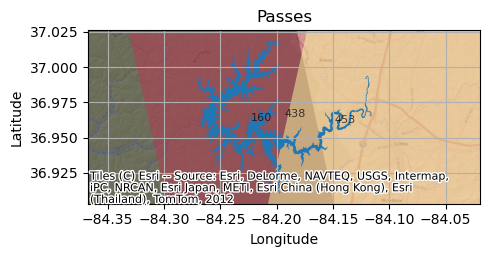

In [24]:
gd_track_subset = gd_track[gd_track.intersects(BUFFERED_RESERVOIR_GEOMETRY)]
gd_nadir_subset = gd_nadir[gd_nadir.intersects(BUFFERED_RESERVOIR_GEOMETRY)]

cmap = mpl.colormaps['inferno']
gd_track_subset['color'] = [mpl.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, len(gd_track_subset.groupby('ID_PASS')))]
gd_nadir_subset['color'] = [mpl.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, len(gd_nadir_subset.groupby('ID_PASS')))]

# Plot base map (OpenStreetMap tiles not supported directly in pure matplotlib)
# You would need contextily or cartopy for background tiles, but skipping here for simplicity

fig, ax = plt.subplots(figsize=(5, 5))

# Plot the geometries
gd_track_subset.plot(
    ax=ax,
    color=gd_track_subset['color'],
    alpha=0.5,
    linewidth=2
)
if len(gd_nadir_subset) > 0:
    gd_nadir_subset.plot(
        ax=ax,
        color=gd_track_subset.clip(RESERVOIR_GDF.total_bounds)['color'],
        alpha=0.5,
        linewidth=2
    )

# Set bounds
xmin = BUFFERED_RESERVOIR_GDF.total_bounds[0]
xmax = BUFFERED_RESERVOIR_GDF.total_bounds[2]
ymin = BUFFERED_RESERVOIR_GDF.total_bounds[1]
ymax = BUFFERED_RESERVOIR_GDF.total_bounds[3]
plot_xmin = xmin - (xmax - xmin)*0.5
plot_xmax = xmax + (xmax - xmin)*0.5
plot_ymin = ymin - (ymax - ymax)*0.5
plot_ymax = ymax + (ymax - ymax)*0.5
ax.set_xlim(plot_xmin, plot_xmax)
ax.set_ylim(plot_ymin, plot_ymax)

# Optional: Label with ID_PASS
for feature in gd_track_subset.iterfeatures():
    feature['id'] = int(feature['id'])
    row = gpd.GeoDataFrame.from_features([feature])
    id_pass = row['ID_PASS'].values[0]

    row = row.clip_by_rect(xmin, ymin, xmax, ymax)
    x, y = row.geometry.centroid.x, row.geometry.centroid.y

    ax.text(x, y, str(id_pass), fontsize=8, alpha=0.7)


RESERVOIR_GDF.plot(ax=ax)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap, crs=RESERVOIR_GDF.crs)

# Set labels
ax.set_title("Passes")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
gd_track_subset

,ID_PASS,START_TIME,geometry,color
231,160,Day 06 16:20:00,"MULTIPOLYGON (((-162.39599 77.75149, -162.4252...",#000004
635,438,Day 16 14:42:20,"MULTIPOLYGON (((-159.33885 77.75046, -159.2979...",#bc3754
657,453,Day 17 03:34:00,"MULTIPOLYGON (((-174.10657 -77.57287, -174.123...",#fcffa4


### load data

In [31]:
# load
from pathlib import Path
import pandas as pd

swot_save_dir = Path('/tiger1/pdas47/resorr-swot/data/swot/swot_karin_intermediate')
swot_save_dir.mkdir(exist_ok=True)

dsses = []
reservoirs = []
available = []
platforms = []
times = []
ds_dict = {reservoir_id: None for reservoir_id in selected_reservoirs}

for reservoir_id in selected_reservoirs:
    fp = swot_save_dir / f'{reservoir_id}.nc'

    if not fp.exists():
        reservoirs.append(reservoir_id)
        dsses.append(None)
        available.append(False)
        platforms.append(None)
        times.append(None)
        continue
    
    ds = xr.open_dataset(fp, chunks='auto', engine='netcdf4', decode_coords='all', )
    dsses.append(ds)
    reservoirs.extend([reservoir_id] * len(ds.time))
    available.extend([True] * len(ds.time))
    platforms.extend(['swot'] * len(ds.time))
    times.extend(ds.time.values)

df = pd.DataFrame({
    'reservoir': reservoirs,
    'available': available,
    'platform': platforms,
    'time': times,
})

ds_dict = {reservoir_id: ds for reservoir_id, ds in zip(selected_reservoirs, dsses)}
df = pd.merge(df, RESERVOIR_GDF[['id', 'geometry']], left_on='reservoir', right_on='id', suffixes=(False, False))
df.head()

,reservoir,available,platform,time,id,geometry
0,1,True,swot,2023-08-06,1,"POLYGON ((-84.19981 37.01885, -84.19954 37.018..."
1,1,True,swot,2023-08-27,1,"POLYGON ((-84.19981 37.01885, -84.19954 37.018..."
2,1,True,swot,2023-09-06,1,"POLYGON ((-84.19981 37.01885, -84.19954 37.018..."
3,1,True,swot,2023-09-17,1,"POLYGON ((-84.19981 37.01885, -84.19954 37.018..."
4,1,True,swot,2023-10-07,1,"POLYGON ((-84.19981 37.01885, -84.19954 37.018..."


## plot data for a single reservoir

In [32]:
ds = ds_dict[RESERVOIR]
ds

<xarray.Dataset> Size: 49MB
Dimensions:            (time: 60, y: 161, x: 180)
Coordinates:
  * x                  (x) float64 1kB 7.409e+05 7.41e+05 ... 7.588e+05
  * y                  (y) float64 1kB 4.087e+06 4.087e+06 ... 4.103e+06
    reservoir          int64 8B ...
    spatial_ref        int64 8B ...
    crs                int64 8B ...
  * time               (time) datetime64[ns] 480B 2023-08-06 ... 2025-06-14
Data variables:
    water_area         (time, y, x) float32 7MB dask.array<chunksize=(60, 161, 180), meta=np.ndarray>
    water_area_qual    (time, y, x) float32 7MB dask.array<chunksize=(60, 161, 180), meta=np.ndarray>
    water_frac         (time, y, x) float32 7MB dask.array<chunksize=(60, 161, 180), meta=np.ndarray>
    water_frac_uncert  (time, y, x) float32 7MB dask.array<chunksize=(60, 161, 180), meta=np.ndarray>
    wse                (time, y, x) float32 7MB dask.array<chunksize=(60, 161, 180), meta=np.ndarray>
    wse_uncert         (time, y, x) float32 7MB dask.array<chunksize=(60, 161, 180), meta=np.ndarray>
    wse_qual           (time, y, x) float32 7MB dask.array<chunksize=(60, 161, 180), meta=np.ndarray>
    pass_ids           (time) <U3 720B dask.array<chunksize=(60,), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    source:                        Ka-band radar interferometer
    history:                       2024-07-19T22:59:29Z : Creation
    platform:                      SWOT
    references:                    V1.2.1
    ...                            ...
    x_min:                         611700.0
    x_max:                         766300.0
    y_min:                         4024000.0
    y_max:                         4178600.0
    institution:                   CNES
    product_version:               01

## Classify water for single reservoir

In [33]:
import rioxarray

ds = ds.rio.set_spatial_dims('y', 'x')
ds = ds.rio.write_crs(utm_crs)
ds = ds.rio.clip(BUFFERED_RESERVOIR_GDF.to_crs(ds.rio.crs).geometry.values)
ds = ds.sel(time=slice(start_date, None))
ds

<xarray.Dataset> Size: 36MB
Dimensions:            (x: 156, y: 137, time: 60)
Coordinates:
  * x                  (x) float64 1kB 7.421e+05 7.422e+05 ... 7.576e+05
  * y                  (y) float64 1kB 4.088e+06 4.088e+06 ... 4.101e+06
    reservoir          int64 8B ...
    crs                int64 8B ...
  * time               (time) datetime64[ns] 480B 2023-08-06 ... 2025-06-14
    spatial_ref        int64 8B 0
Data variables:
    water_area         (time, y, x) float32 5MB dask.array<chunksize=(60, 137, 156), meta=np.ndarray>
    water_area_qual    (time, y, x) float32 5MB dask.array<chunksize=(60, 137, 156), meta=np.ndarray>
    water_frac         (time, y, x) float32 5MB dask.array<chunksize=(60, 137, 156), meta=np.ndarray>
    water_frac_uncert  (time, y, x) float32 5MB dask.array<chunksize=(60, 137, 156), meta=np.ndarray>
    wse                (time, y, x) float32 5MB dask.array<chunksize=(60, 137, 156), meta=np.ndarray>
    wse_uncert         (time, y, x) float32 5MB dask.array<chunksize=(60, 137, 156), meta=np.ndarray>
    wse_qual           (time, y, x) float32 5MB dask.array<chunksize=(60, 137, 156), meta=np.ndarray>
    pass_ids           (time) <U3 720B dask.array<chunksize=(60,), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    source:                        Ka-band radar interferometer
    history:                       2024-07-19T22:59:29Z : Creation
    platform:                      SWOT
    references:                    V1.2.1
    ...                            ...
    x_min:                         611700.0
    x_max:                         766300.0
    y_min:                         4024000.0
    y_max:                         4178600.0
    institution:                   CNES
    product_version:               01

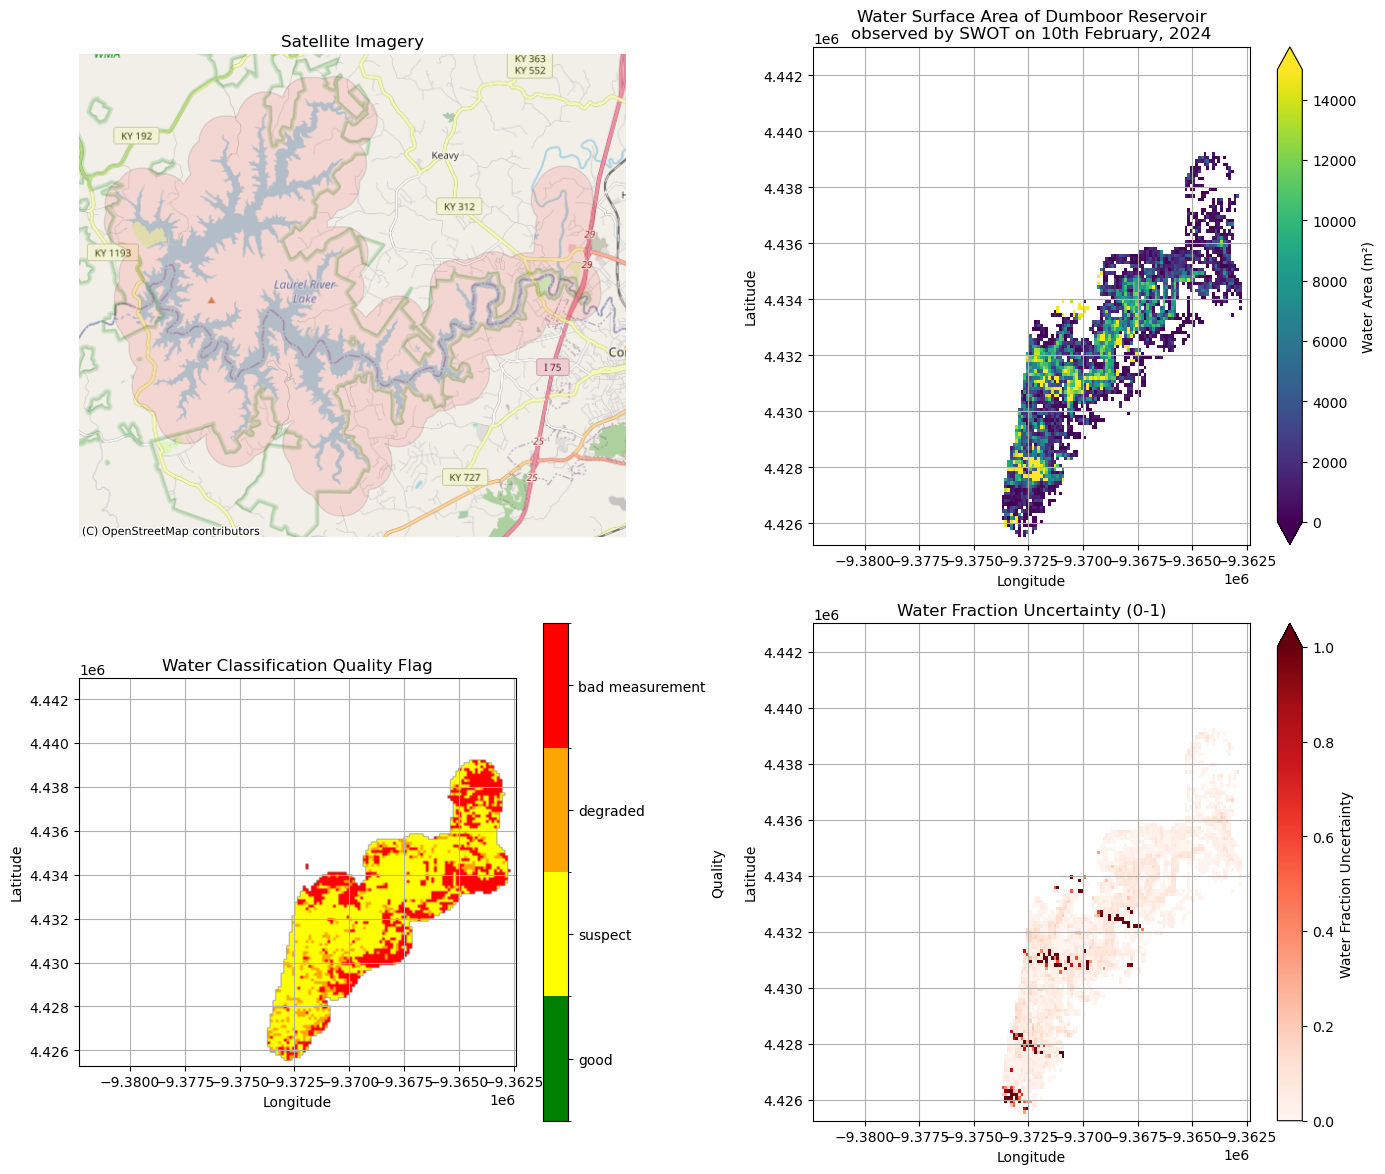

In [34]:
# Ensure all data is in EPSG:3857 for tile overlays
buffered_roi_gdf = BUFFERED_RESERVOIR_GDF.to_crs(epsg=3857)
ds_proj = ds.rio.reproject("EPSG:3857")  # requires rioxarray

# Select time slice
t_sel = '2024-01-01'
water_area = ds_proj['water_area'].sel(time=t_sel, method='nearest')
water_area_qual = ds_proj['water_area_qual'].sel(time=t_sel, method='nearest')
water_uncert = ds_proj['water_frac_uncert'].sel(time=t_sel, method='nearest')

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# -------------------------------
# 1. Satellite Imagery + Polygon
ax = axes[0, 0]
buffered_roi_gdf.plot(ax=ax, color='red', alpha=0.1, edgecolor='k')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Satellite Imagery")
ax.axis('off')

# -------------------------------
# 2. Water Surface Area
ax = axes[0, 1]
water_area.plot(
    ax=ax, cmap='viridis', vmin=0, vmax=15000,
    cbar_kwargs={'label': 'Water Area (m²)'}
)
ax.set_title("Water Surface Area of Dumboor Reservoir\nobserved by SWOT on 10th February, 2024")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)

# -------------------------------
# 3. Water Area Quality Flag
ax = axes[1, 0]

# Define a custom colormap for quality levels
from matplotlib.colors import ListedColormap, BoundaryNorm

colors = ['green', 'yellow', 'orange', 'red']
labels = ['good', 'suspect', 'degraded', 'bad measurement']
cmap = ListedColormap(colors)
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(bounds, len(colors))

im = ax.imshow(water_area_qual.values, cmap=cmap, norm=norm,
               extent=[water_area_qual.x.min(), water_area_qual.x.max(),
                       water_area_qual.y.min(), water_area_qual.y.max()],
               origin='upper')
cbar = fig.colorbar(im, ax=ax, ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels(labels)
cbar.set_label("Quality")

ax.set_title("Water Classification Quality Flag")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)

# -------------------------------
# 4. Water Fraction Uncertainty
ax = axes[1, 1]
water_uncert.plot(
    ax=ax, cmap='Reds', vmin=0, vmax=1,
    cbar_kwargs={'label': 'Water Fraction Uncertainty'}
)
ax.set_title("Water Fraction Uncertainty (0-1)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)

# -------------------------------
plt.tight_layout()
plt.show()

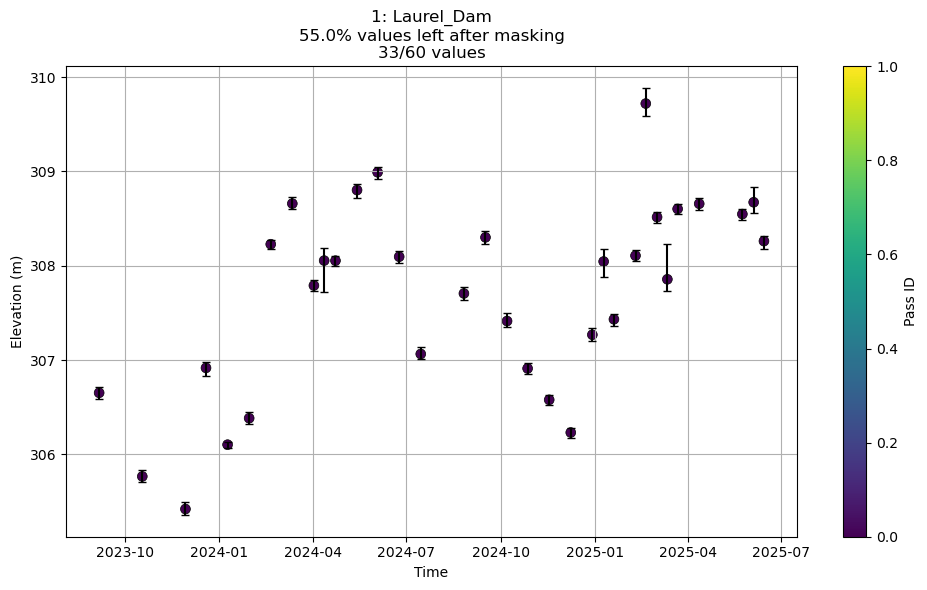

In [35]:
xy_mask = ds['wse_uncert'] < 0.1
uncertainty_masked_wse = ds['wse'].where(xy_mask).chunk(dict(x=-1, y=-1))

# Calculate the 25% and 75% IQR elevations
elevations = uncertainty_masked_wse.median(dim=('x', 'y')).values

q25 = uncertainty_masked_wse.quantile(0.25, dim=('x', 'y')).values
q75 = uncertainty_masked_wse.quantile(0.75, dim=('x', 'y')).values  # Corrected quantile to 0.75

time_mask = (q75-q25) > 0.5  # mask out values where IQR distance is > 0.5 m (50 cm)

elevations = np.where(time_mask, np.nan, elevations)

pass_ids = ds['pass_ids'].values
time = ds['time'].values

# Calculate the fraction of values left after masking
values_left_pct = sum(~np.isnan(elevations))*100/len(time)
fraction = f"{sum(~np.isnan(elevations))}/{len(time)}"

# Masked data
elevations_masked = elevations
q25_masked = np.where(np.isnan(elevations_masked), np.nan, q25)
q75_masked = np.where(np.isnan(elevations_masked), np.nan, q75)

cmap = mpl.colormaps['viridis']
pass_ids_masked = np.where(np.isnan(elevations_masked), 'none', pass_ids)
unique_pass_ids = np.unique(pass_ids_masked)
pass_id_color_dict = {pass_id: mpl.colors.rgb2hex(cmap(i)) for i, pass_id in enumerate(unique_pass_ids)}
colors = [pass_id_color_dict[pass_id] for pass_id in pass_ids_masked]

# Compute error bars
yerr_lower = elevations_masked - q25_masked
yerr_upper = q75_masked - elevations_masked
yerr = [yerr_lower, yerr_upper]

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot with color by pass_ids
sc = ax.scatter(
    time, elevations_masked,
    c=colors,
    s=50, edgecolor='k', linewidth=0.5
)

# Add error bars
ax.errorbar(
    time, elevations_masked,
    yerr=yerr, fmt='none', ecolor='black', elinewidth=1.5, capsize=3
)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Pass ID")

# Title and labels
ax.set_title(
    f"{RESERVOIR}: {RESERVOIR_NAME}\n"
    f"{values_left_pct:.1f}% values left after masking\n{fraction} values"
)
ax.set_xlabel("Time")
ax.set_ylabel("Elevation (m)")
ax.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# save elevations
elevation_save_dir = Path("/tiger1/pdas47/resorr-swot/data/swot/swot_karin")
save_fp = elevation_save_dir / f"{RESERVOIR}.csv"

elevations
time
# Create a DataFrame with elevations and time
elevation_df = pd.DataFrame({
    'time': time,
    'elevation': elevations
})

# Save the DataFrame to a CSV file
elevation_df.to_csv(save_fp, index=False)

##### end of notebook